# MNIST Classification with MLP -- Customized training loops --
In this notebook, I describe how to implement MLP using tf.keras.  
Training loop is defined by customized step-by-step training loops.  

In [1]:
import tensorflow as tf
import time
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import os
%matplotlib inline

print("tensorflow version: ", tf.__version__)
print("numpy version: ", np.__version__)
print("scikit learn version: ", sklearn.__version__)
print("matplotlib version: ", matplotlib.__version__)

tensorflow version:  2.3.0
numpy version:  1.19.1
scikit learn version:  0.23.2
matplotlib version:  3.3.0


## 1. Load data & preprocessing
In this notebook, I use pre-defined mnist dataset.

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
# Convert images into flattern array
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

In [4]:
# Normalize
X_train = X_train / 255.0
X_test = X_test / 255.0

In [5]:
# Convert into float32
X_train = np.float32(X_train)
X_test = np.float32(X_test)

In [6]:
# Split original training dataset into train/validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

## 2. Create tf.data.Dataset

In [7]:
train_batch_size = 64
test_batch_size = 1
n_classes = 10

# Build source dataset for training
X_train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
y_train_dataset = tf.data.Dataset.from_tensor_slices(y_train).map(lambda x : tf.cast(tf.one_hot(x, n_classes), tf.float32))
train_dataset = tf.data.Dataset.zip((X_train_dataset, y_train_dataset)).batch(train_batch_size)

# Build source dataset for validation
X_valid_dataset = tf.data.Dataset.from_tensor_slices(X_val)
y_valid_dataset = tf.data.Dataset.from_tensor_slices(y_val).map(lambda x : tf.cast(tf.one_hot(x, n_classes), tf.float32))
validation_dataset = tf.data.Dataset.zip((X_valid_dataset, y_valid_dataset)).batch(train_batch_size)

# Build source dataset for test
X_test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
y_test_dataset = tf.data.Dataset.from_tensor_slices(y_test).map(lambda x : tf.cast(tf.one_hot(x, n_classes), tf.float32))
test_dataset = tf.data.Dataset.zip((X_test_dataset, y_test_dataset)).batch(test_batch_size)

### Debug dataset

In [8]:
def visualize_batch(X_batch, y_batch, y_pred=None):
    """visualize 1D ndarray"""
    assert len(X_batch) == len(y_batch)
    
    n_col = 10
    if len(X_batch) % n_col ==0:
        n_row=len(X_batch)//n_col
    else:
        n_row=len(X_batch)//n_col + 1
    
    fig = plt.figure(figsize=(20,15))
    
    for idx in range(len(y_batch)):
        if y_pred is not None:
            ax = fig.add_subplot(n_row, n_col, idx+1, title="gt={}, pred={}".format(np.argmax(y_batch[idx]), y_pred[idx]))
        else:
            ax = fig.add_subplot(n_row, n_col, idx+1, title="gt={}".format(np.argmax(y_batch[idx])))
        ax.imshow(X_batch[idx].reshape(28,28), cmap='gray')
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
    plt.show()

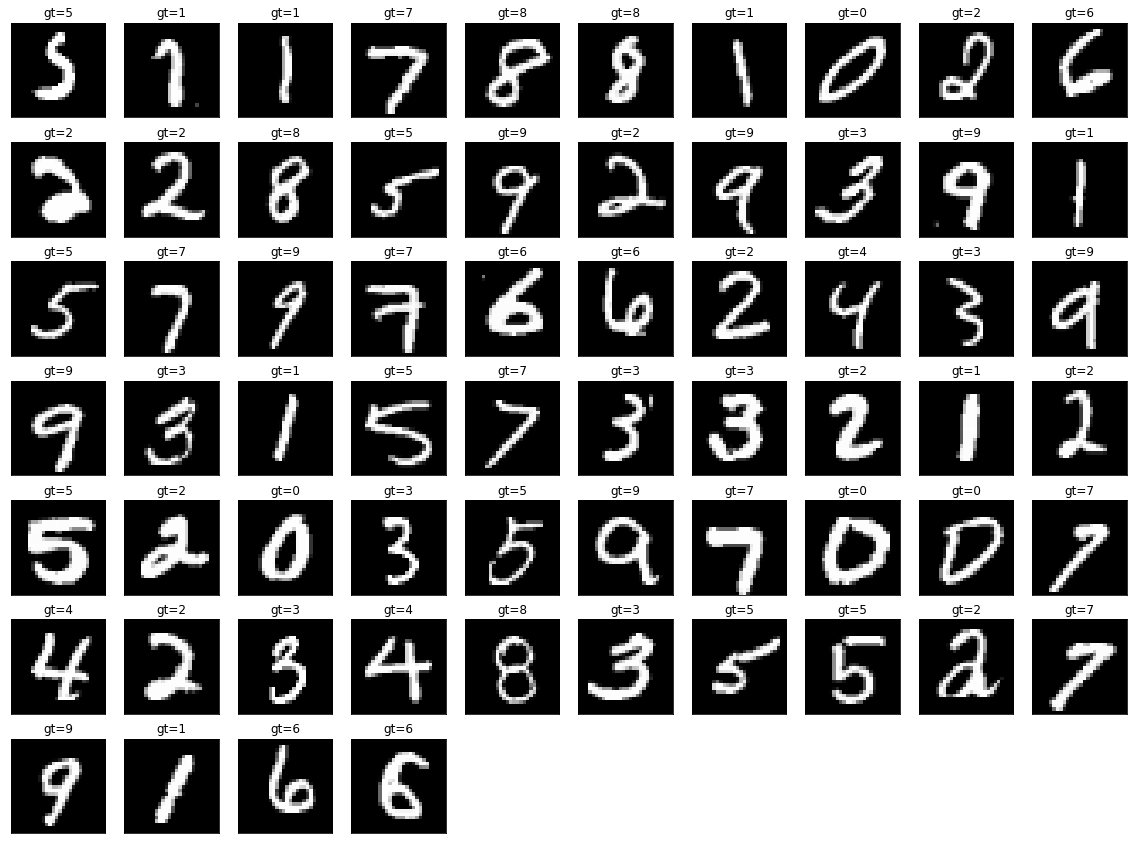

In [9]:
for X_batch, y_batch in train_dataset:
    visualize_batch(X_batch.numpy(), y_batch.numpy())
    break

## 3. Create MLP model
Network structure (2 hidden layers):  
FC(256) - FC(512) - FC(10)

In [10]:
class MLP(tf.keras.Model):
    def __init__(self, units1, units2, units3):
        super(MLP, self).__init__(name="MLP")
        self.dense1 = tf.keras.layers.Dense(units1, activation=tf.nn.relu, kernel_initializer=tf.initializers.truncated_normal(stddev=0.1))
        self.dense2 = tf.keras.layers.Dense(units2, activation=tf.nn.relu, kernel_initializer=tf.initializers.truncated_normal(stddev=0.1))
        self.dense3 = tf.keras.layers.Dense(units3, activation=None, kernel_initializer=tf.initializers.truncated_normal(stddev=0.1))
    
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

## 4. Training

In [11]:
lr = 0.0001

n_dense1 = 256
n_dense2 = 512
n_dense3 = n_classes

epochs = 15
checkpoint_path = './checkpoints_2/model_{epoch:04d}.ckpt'

# ------------------------------------------------------------

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
accuracy = tf.keras.metrics.CategoricalAccuracy()
optimizer = tf.keras.optimizers.Adam(lr)

# Define model
model = MLP(n_dense1, n_dense2, n_dense3)

@tf.function
def train_on_batch(model, X, y, accuracy_i):
    # Open a GradientTape
    with tf.GradientTape() as tape:
        logits = model(X)
        loss_value = loss(y, logits)

    # Coumpute gradients
    gradients = tape.gradient(loss_value, model.trainable_weights)

    # Apply back propagation
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    # Update the runnning accuracy
    accuracy_i.update_state(y, logits)
    return loss_value

@tf.function
def eval_on_batch(model, X, y, accuracy_i):
    logits = model(X)
    loss_value = loss(y, logits)
    accuracy_i.update_state(y, logits)
    return loss_value
    
    
for epoch in range(epochs):
    
    # Training
    train_losses = []
    accuracy.reset_states()
    
    for step, (X, y) in enumerate(train_dataset):
        train_loss = train_on_batch(model, X, y, accuracy)
        train_losses.append(train_loss)
    
    train_accuracy = accuracy.result()
    train_loss = np.average(train_losses)
    
    # Validation
    accuracy.reset_states()
    validation_losses = []
    
    for X, y in validation_dataset:
        val_loss = eval_on_batch(model, X, y, accuracy)
        validation_losses.append(val_loss)

    validation_accuracy = accuracy.result()
    validation_loss = np.average(validation_losses)
    
    print('Epoch: {}, loss: {:.5f}, accuracy: {:.5f}, val_loss: {:.5f}, val_accuracy: {:.5f}'.format(
        epoch, train_loss, train_accuracy, validation_loss, validation_accuracy
    ))

Epoch: 0, loss: 0.12256, accuracy: 0.81400, val_loss: 0.05984, val_accuracy: 0.91875
Epoch: 1, loss: 0.04974, accuracy: 0.93238, val_loss: 0.04343, val_accuracy: 0.93900
Epoch: 2, loss: 0.03768, accuracy: 0.94842, val_loss: 0.03582, val_accuracy: 0.94917
Epoch: 3, loss: 0.03089, accuracy: 0.95781, val_loss: 0.03106, val_accuracy: 0.95533
Epoch: 4, loss: 0.02620, accuracy: 0.96419, val_loss: 0.02779, val_accuracy: 0.95967
Epoch: 5, loss: 0.02268, accuracy: 0.96990, val_loss: 0.02544, val_accuracy: 0.96350
Epoch: 6, loss: 0.01989, accuracy: 0.97402, val_loss: 0.02366, val_accuracy: 0.96608
Epoch: 7, loss: 0.01761, accuracy: 0.97744, val_loss: 0.02231, val_accuracy: 0.96892
Epoch: 8, loss: 0.01570, accuracy: 0.98004, val_loss: 0.02124, val_accuracy: 0.97075
Epoch: 9, loss: 0.01407, accuracy: 0.98229, val_loss: 0.02043, val_accuracy: 0.97242
Epoch: 10, loss: 0.01266, accuracy: 0.98440, val_loss: 0.01980, val_accuracy: 0.97367
Epoch: 11, loss: 0.01144, accuracy: 0.98667, val_loss: 0.01930, 

## 5. Test

In [12]:
accuracy.reset_states()
test_losses = []

for X, y in test_dataset:
    test_loss = eval_on_batch(model, X, y, accuracy)
    test_losses.append(test_loss)

test_accuracy = accuracy.result()
test_loss = np.average(test_losses)

print('loss: {:.5f}, accuracy: {:.5f}'.format(test_loss, test_accuracy))

loss: 0.01657, accuracy: 0.97510


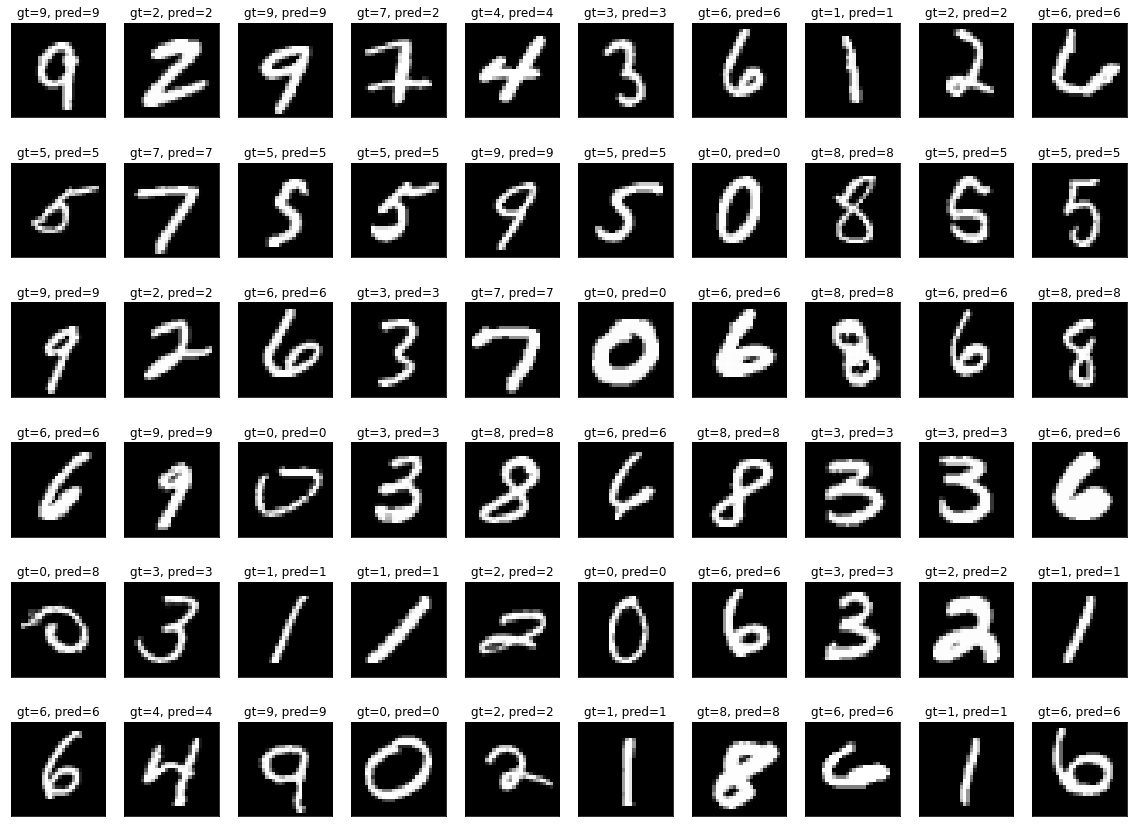

In [13]:
index = np.random.choice(np.arange(0, len(y_test)), size=60)
test_input = X_test[index]
y_true = tf.keras.utils.to_categorical(y_test[index], num_classes=n_classes)

predicted = model.predict(test_input)
predicted_label = np.argmax(predicted, axis=1)

visualize_batch(test_input, y_true, predicted_label)